# Financial time series <a id='financial-time-series'></a>

Python and, in particular, `pandas` can easily deal with the most common type of financial data - **time series data**. We are going to look at the basics of using price and return data. This section follows Chapter 8 of [Python for Finance, 2e](https://www.oreilly.com/library/view/python-for-finance/9781492024323/) and the fourth DataCamp assignment that discusses `pandas` time series.

We'll cover importing time series data and getting some summary statistics, as well as **return calculations**, **resampling**, or changing the periodicity of the data (i.e. going from daily to monthly to annual), and **rolling statistics**, such as finding moving averages and other statistics over rolling windows (e.g. one month of trading days). 

Time series data means handling dates. There is a [DataCamp tutorial on datetime objects](https://www.datacamp.com/community/tutorials/python-datetime).

We'll start with the usual sort of set-up and our familiar stock data. Our data is going to have a particular set-up in this section. Each column is going to represent both a security and something about that security. So, Apple's price. Or, Apple's return. This is a very common way to see financial data, but it is not the only way that this data can be organized.


## Set-up and descriptives

In [1]:
# Set-up

import numpy as np
import pandas as pd

# Date functionality
from datetime import datetime
from datetime import timedelta

import janitor
from janitor import clean_names

# all of matplotlib
import matplotlib as mpl 

# refer to the pyplot part of matplot lib more easily. Just use plt!
import matplotlib.pyplot as plt

# importing the style package
from matplotlib import style
from matplotlib.ticker import StrMethodFormatter

# generating random numbers
from numpy.random import normal, seed
from scipy.stats import norm

# seaborn
import seaborn as sns

# Keeps warnings from cluttering up our notebook. 
import warnings
warnings.filterwarnings('ignore')

# Include this to have plots show up in your Jupyter notebook.
%matplotlib inline 

# Some plot options that will apply to the whole workbook
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'


# Read in some eod prices
stocks = pd.read_csv('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)  

stocks.dropna(inplace=True)  

stocks = clean_names(stocks)

stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2138 entries, 2010-01-04 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   aapl_o  2138 non-null   float64
 1   msft_o  2138 non-null   float64
 2   intc_o  2138 non-null   float64
 3   amzn_o  2138 non-null   float64
 4   gs_n    2138 non-null   float64
 5   spy     2138 non-null   float64
 6   _spx    2138 non-null   float64
 7   _vix    2138 non-null   float64
 8   eur=    2138 non-null   float64
 9   xau=    2138 non-null   float64
 10  gdx     2138 non-null   float64
 11  gld     2138 non-null   float64
dtypes: float64(12)
memory usage: 217.1 KB


We are using `pandas` DataFrames, which have many built-in ways to deal with time series data. We have made our **index** the date. This is important - having the date be our index opens up various date-related methods. 

Let's use `pandas` plot to make a quick figure of all of the prices over the time period in our data. Remember, `pandas` has its own plotting functions. They are very useful for quick plots like this. Because the date is our index, `pandas` knows to put that on the x-axis, right where we want it.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


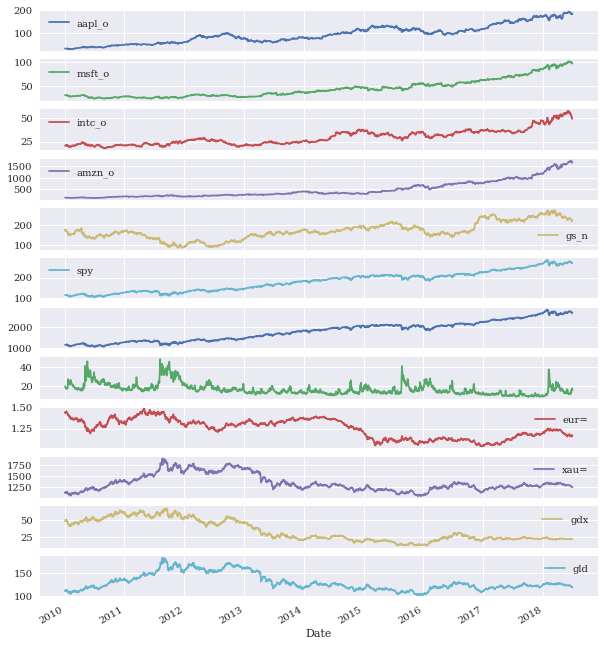

In [2]:
stocks.plot(figsize=(10, 12), subplots=True);  

We can use `.describe()` to look at our prices.

In [3]:
stocks.describe().round(2) 

,aapl_o,msft_o,intc_o,amzn_o,gs_n,spy,_spx,_vix,eur=,xau=,gdx,gld
count,2138.00,2138.00,2138.00,2138.00,2138.00,2138.00,2138.00,2138.00,2138.00,2138.00,2138.00,2138.00
mean,93.46,44.56,29.36,480.46,170.22,180.32,1802.71,17.03,1.25,1348.91,33.57,130.09
std,40.55,19.53,8.17,372.31,42.48,48.19,483.34,5.88,0.11,188.21,15.17,18.78
min,27.44,23.01,17.66,108.61,87.70,102.20,1022.58,9.14,1.04,1051.36,12.47,100.50
25%,60.29,28.57,22.51,213.60,146.61,133.99,1338.57,13.07,1.13,1222.49,22.14,117.40
50%,90.55,39.66,27.33,322.06,164.43,186.32,1863.08,15.58,1.27,1292.68,25.62,124.00
75%,117.24,54.37,34.71,698.85,192.13,210.99,2108.94,19.07,1.35,1427.57,48.34,139.00
max,193.98,102.49,57.08,1750.08,273.38,286.58,2872.87,48.00,1.48,1897.10,66.63,184.59


We can use `.aggregate()` to create our own set of descriptives. 

In [4]:
stocks.aggregate([min,  
                np.mean,  
                np.std,  
                np.median,  
                max]  
).round(2)

,aapl_o,msft_o,intc_o,amzn_o,gs_n,spy,_spx,_vix,eur=,xau=,gdx,gld
min,27.44,23.01,17.66,108.61,87.70,102.20,1022.58,9.14,1.04,1051.36,12.47,100.50
mean,93.46,44.56,29.36,480.46,170.22,180.32,1802.71,17.03,1.25,1348.91,33.57,130.09
std,40.55,19.53,8.17,372.31,42.48,48.19,483.34,5.88,0.11,188.21,15.17,18.78
median,90.55,39.66,27.33,322.06,164.43,186.32,1863.08,15.58,1.27,1292.68,25.62,124.00
max,193.98,102.49,57.08,1750.08,273.38,286.58,2872.87,48.00,1.48,1897.10,66.63,184.59


### Dates

The fourth Datacamp assignment covers some additional date basics. Two libraries are being used here: `datetime` and `pandas`. We can use `pandas` to objects and methods that help us deal with dates. Obviously, we need to handle a variety of time periods in finance.

We can define a `TimeStamp` and see that they are a particular object-type in Python. **All objects come with methods and attributes.** This is a generic idea from computer science called **object oriented programming**. 

In [5]:
my_date = pd.Timestamp(datetime(2022, 2, 23))
print(type(my_date))
my_date

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


Timestamp('2022-02-23 00:00:00')

Here's an example of an **attribute** for a `TimeStamp` object. You can also do `.month`, `.day`, `.dayofweek`, etc. 

In [6]:
my_date.year

2022

We can add and subtract with dates using `timedelta`. Note that `datetime` no longer wants you to just add or subtract a number from a date.

There's both a `datetime` `timedelta` and a `pandas` `Timedelta`. You can read about the `pandas` version [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timedelta.html). 

In [7]:
my_date + timedelta(days=7)

Timestamp('2022-03-02 00:00:00')

Using the `pandas` version, just to highlight that different libraries have similar functionality. The `datetime` library and the `pandas` library are different things. But, they can do similar operations with time, even if the syntax varies a bit.

In [8]:
my_date + pd.Timedelta(7, "d")


Timestamp('2022-03-02 00:00:00')

`pandas` has a set of tools related to a **period** in time. You can define a [period](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Period.html), get attributes, and change its frequency. Changing the frequency means changing how `pandas` thinks about the period. Is this month? Is this a particular day?

Let's define a period as February 2022. 

In [9]:
period = pd.Period('2022-02')
period

Period('2022-02', 'M')

We can then change that to a daily frequency. Note how, by default, `pandas` puts us at the end of the month. 

In [10]:
period.asfreq('D')

Period('2022-02-28', 'D')

This can be really helpful when some Excel data comes in as, say "May-2019" and we want to get that to be an end of month date, like "5/31/19". The actual day is ambiguous when just dealing with month and year.

With the date as our index, we can pull certain dates and columns. Here's Apple's price on 2017-6-1. 

In [11]:
stocks.loc['2017-6-1', 'aapl_o']

153.18

Here's all of the columns, but just for a subset of dates.

In [12]:
stocks.loc['2015-3':'2016-2',:]

,aapl_o,msft_o,intc_o,amzn_o,gs_n,spy,_spx,_vix,eur=,xau=,gdx,gld
Date,,,,,,,,,,,,
2015-03-02,129.09,43.880,34.060,385.655,191.79,211.9900,2117.39,13.04,1.1183,1206.70,20.76,115.68
2015-03-03,129.36,43.280,34.095,384.610,191.27,211.1200,2107.78,13.86,1.1174,1203.31,20.38,115.47
2015-03-04,128.54,43.055,34.120,382.720,189.67,210.2301,2098.53,14.23,1.1077,1199.45,20.04,115.11
2015-03-05,126.41,43.110,33.730,387.830,190.08,210.4600,2101.04,14.04,1.1028,1198.20,20.08,115.00
2015-03-06,126.60,42.360,33.190,380.090,186.91,207.5000,2071.26,15.20,1.0843,1166.72,18.58,111.86
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-02-23,94.69,51.180,28.800,552.940,144.91,192.3200,1921.27,20.98,1.1017,1227.06,18.92,117.22
2016-02-24,96.10,51.360,29.190,554.040,145.56,193.2000,1929.80,20.72,1.1011,1228.96,19.11,117.61
2016-02-25,96.76,52.100,29.620,555.150,148.25,195.5400,1951.70,19.11,1.1021,1234.26,19.39,117.92


## Calculating returns

We can start by just calculating the price change from day-to-day using `pandas` `diff()`. This function is described [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html). Notice how the first day in the data is now NaN, since you can't calculate a change without the previous day.

Since there's no `=`, I am not saving the data. Just showing you what the function does.

In [13]:
stocks.diff().head() 

,aapl_o,msft_o,intc_o,amzn_o,gs_n,spy,_spx,_vix,eur=,xau=,gdx,gld
Date,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.052857,0.010,-0.01,0.79,3.06,0.30,3.53,-0.69,-0.0043,-1.35,0.46,-0.10
2010-01-06,-0.487142,-0.190,-0.07,-2.44,-1.88,0.08,0.62,-0.19,0.0044,19.85,1.17,1.81
2010-01-07,-0.055714,-0.318,-0.20,-2.25,3.41,0.48,4.55,-0.10,-0.0094,-6.60,-0.24,-0.69
2010-01-08,0.200000,0.208,0.23,3.52,-3.36,0.38,3.29,-0.93,0.0094,4.20,0.74,0.55


Sometimes we want price changes. Other times we want `pandas` `pct_change()`. See [this for more](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pct_change.html). This function allows us to calculate price returns using the percent change. The default is to look back one period, or one day in this case. 

In [14]:
stocks.pct_change().mul(100).round(3).head()  

,aapl_o,msft_o,intc_o,amzn_o,gs_n,spy,_spx,_vix,eur=,xau=,gdx,gld
Date,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.173,0.032,-0.048,0.590,1.768,0.265,0.312,-3.443,-0.298,-0.121,0.964,-0.091
2010-01-06,-1.591,-0.614,-0.335,-1.812,-1.067,0.070,0.055,-0.982,0.306,1.774,2.429,1.650
2010-01-07,-0.185,-1.033,-0.962,-1.701,1.957,0.422,0.400,-0.522,-0.652,-0.580,-0.486,-0.619
2010-01-08,0.665,0.683,1.117,2.708,-1.891,0.333,0.288,-4.879,0.657,0.371,1.507,0.496


I'm multiplying by 100 just for the display of the data. 

The percent change is called a **linear return**. Or, **simple return**. This is different from **log returns**, or **compounded returns**. Both types of returns are correct and useful. They are just used for different things.

The formula for simple returns (R) is:

\begin{align}
R_{t} = \frac{V_t}{V_{t-1}} - 1
\end{align}

where R is the simple return based on the percent change and V is the cash flow, including price and dividends (if any). 

The formula for log returns (r) is:

\begin{align}
r_{t} = ln(\frac{V_t}{V_{t-1}}) = ln(1 + R_{t})
\end{align}


See [this article](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1586656) for more on why this difference is important. In short, we need the mean of simple returns when doing portfolio optimization, as these returns work with a weighted average. Simple returns **aggregate across assets**. Log returns, however, **aggregate across time**. In other words, the cumulative return using log returns is the sum of individual log returns over the time period. You definitely can't do that with simple returns!

Here's a [brief video](https://www.youtube.com/watch?v=PtoUlt3V0CI) that describes the same thing using Excel.

Finally, [this chapter](https://faculty.washington.edu/ezivot/econ424/returnCalculations.pdf) has everything you've ever want to know about return calculations. See pgs. 16 and 17 for log returns.

We can calculate log returns using `np.log` and `.shift()` from `pandas`. Let's look at what `.shift()` does. Compare the following:

In [15]:
stocks

,aapl_o,msft_o,intc_o,amzn_o,gs_n,spy,_spx,_vix,eur=,xau=,gdx,gld
Date,,,,,,,,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82
2010-01-08,30.282827,30.660,20.83,133.52,174.31,114.57,1144.98,18.13,1.4412,1136.10,49.84,111.37
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,182.170000,98.390,50.71,1663.15,221.54,271.00,2717.07,17.33,1.1702,1265.00,22.01,119.89
2018-06-26,184.430000,99.080,49.67,1691.09,221.58,271.60,2723.06,15.92,1.1645,1258.64,21.95,119.26
2018-06-27,184.160000,97.540,48.76,1660.51,220.18,269.35,2699.63,17.91,1.1552,1251.62,21.81,118.58


In [16]:
stocks.shift(1)

,aapl_o,msft_o,intc_o,amzn_o,gs_n,spy,_spx,_vix,eur=,xau=,gdx,gld
Date,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-06,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-07,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-08,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,184.920000,100.410,52.50,1715.67,226.02,274.74,2754.88,13.77,1.1655,1268.49,22.18,120.34
2018-06-26,182.170000,98.390,50.71,1663.15,221.54,271.00,2717.07,17.33,1.1702,1265.00,22.01,119.89
2018-06-27,184.430000,99.080,49.67,1691.09,221.58,271.60,2723.06,15.92,1.1645,1258.64,21.95,119.26


`stocks.shift(1)` has moved the previous price up one row. You can do a also do `stocks.shift(-1)`, which pulls prices from the next period to the previous one.

In [17]:
stocks.shift(-1)

,aapl_o,msft_o,intc_o,amzn_o,gs_n,spy,_spx,_vix,eur=,xau=,gdx,gld
Date,,,,,,,,,,,,
2010-01-04,30.625684,30.960,20.87,134.690,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-05,30.138541,30.770,20.80,132.250,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-06,30.082827,30.452,20.60,130.000,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82
2010-01-07,30.282827,30.660,20.83,133.520,174.31,114.57,1144.98,18.13,1.4412,1136.10,49.84,111.37
2010-01-08,30.015684,30.270,20.95,130.308,171.56,114.73,1146.98,17.55,1.4513,1152.60,50.17,112.85
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,184.430000,99.080,49.67,1691.090,221.58,271.60,2723.06,15.92,1.1645,1258.64,21.95,119.26
2018-06-26,184.160000,97.540,48.76,1660.510,220.18,269.35,2699.63,17.91,1.1552,1251.62,21.81,118.58
2018-06-27,185.500000,98.630,49.25,1701.450,223.42,270.89,2716.31,16.85,1.1567,1247.88,21.93,118.22


So, by dividing `stocks` by `stocks.shift(1)`, we are dividing today's price by yesterday's price. Note how we are dividing one DataFrame by another, in a sense. This is an example of **vectorization**. No need to loop through all of the columns and rows.

In [18]:
rets_log = np.log(stocks / stocks.shift(1))  
rets_log


,aapl_o,msft_o,intc_o,amzn_o,gs_n,spy,_spx,_vix,eur=,xau=,gdx,gld
Date,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001727,0.000323,-0.000479,0.005883,0.017525,0.002644,0.003111,-0.035038,-0.002988,-0.001206,0.009595,-0.000911
2010-01-06,-0.016034,-0.006156,-0.003360,-0.018282,-0.010731,0.000704,0.000545,-0.009868,0.003058,0.017589,0.023999,0.016365
2010-01-07,-0.001850,-0.010389,-0.009662,-0.017160,0.019379,0.004212,0.003993,-0.005233,-0.006544,-0.005814,-0.004876,-0.006207
2010-01-08,0.006626,0.006807,0.011103,0.026717,-0.019093,0.003322,0.002878,-0.050024,0.006544,0.003704,0.014959,0.004951
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,-0.014983,-0.020323,-0.034690,-0.031090,-0.020020,-0.013706,-0.013820,0.229947,0.004024,-0.002755,-0.007694,-0.003746
2018-06-26,0.012330,0.006988,-0.020722,0.016660,0.000181,0.002212,0.002202,-0.084863,-0.004883,-0.005040,-0.002730,-0.005269
2018-06-27,-0.001465,-0.015665,-0.018491,-0.018249,-0.006338,-0.008319,-0.008642,0.117783,-0.008018,-0.005593,-0.006399,-0.005718


We can then use the fact that you can sum up log returns over time to get **cumulative**, or **total** log returns. First, you can use the `.cumsum()` function from `pandas` to transform our daily returns into a cumulative sum. In other words, each period is now the sum of all returns in the previous periods.

In [19]:
rets_log.cumsum()

,aapl_o,msft_o,intc_o,amzn_o,gs_n,spy,_spx,_vix,eur=,xau=,gdx,gld
Date,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001727,0.000323,-0.000479,0.005883,0.017525,0.002644,0.003111,-0.035038,-0.002988,-0.001206,0.009595,-0.000911
2010-01-06,-0.014307,-0.005833,-0.003839,-0.012399,0.006795,0.003347,0.003656,-0.044906,0.000069,0.016383,0.033594,0.015454
2010-01-07,-0.016157,-0.016221,-0.013501,-0.029559,0.026174,0.007560,0.007649,-0.050138,-0.006474,0.010569,0.028718,0.009247
2010-01-08,-0.009531,-0.009414,-0.002398,-0.002842,0.007081,0.010882,0.010527,-0.100162,0.000069,0.014273,0.043677,0.014197
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,1.784829,1.156566,0.887331,2.519375,0.246849,0.871815,0.874694,-0.145291,-0.208232,0.121743,-0.773644,0.087914
2018-06-26,1.797158,1.163555,0.866609,2.536035,0.247030,0.874026,0.876896,-0.230154,-0.213115,0.116703,-0.776374,0.082645
2018-06-27,1.795693,1.147890,0.848119,2.517787,0.240691,0.865708,0.868255,-0.112371,-0.221133,0.111110,-0.782772,0.076927


If you take the cumulative sum of log returns (R) at any point and do e^R, then you get the value of $1 invested at the beginning. We can use `.apply()` to "apply" the exponential function *e* to each value in the DataFrame. If you want to convert back to the cumulative simple return instead, you can do e^R - 1. 

In [20]:
rets_log.cumsum().apply(np.exp)

,aapl_o,msft_o,intc_o,amzn_o,gs_n,spy,_spx,_vix,eur=,xau=,gdx,gld
Date,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,1.001729,1.000323,0.999521,1.005900,1.017680,1.002647,1.003116,0.965569,0.997016,0.998795,1.009642,0.999089
2010-01-06,0.985795,0.994184,0.996169,0.987677,1.006818,1.003353,1.003663,0.956088,1.000069,1.016518,1.034165,1.015574
2010-01-07,0.983973,0.983910,0.986590,0.970874,1.026520,1.007588,1.007679,0.951098,0.993547,1.010625,1.029134,1.009290
2010-01-08,0.990514,0.990630,0.997605,0.997162,1.007107,1.010941,1.010583,0.904691,1.000069,1.014375,1.044645,1.014299
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,5.958559,3.178998,2.428640,12.420836,1.279986,2.391247,2.398141,0.864770,0.812019,1.129464,0.461329,1.091894
2018-06-26,6.032481,3.201292,2.378831,12.629500,1.280217,2.396541,2.403428,0.794411,0.808063,1.123786,0.460071,1.086157
2018-06-27,6.023650,3.151535,2.335249,12.401120,1.272128,2.376688,2.382748,0.893713,0.801610,1.117518,0.457137,1.079964


In [21]:
print(np.exp(1.800839))

6.054725248468137


You can then plot the cumulative returns. Notice how we use the `.` to keep sending the DataFrame through to the next step. Take the raw data, do something to it, do something else to that result, and then plot it.

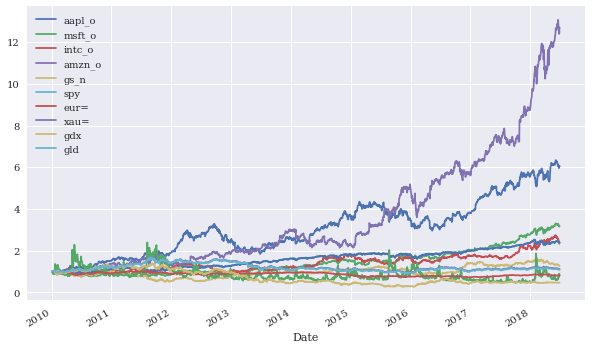

In [22]:
rets_log.cumsum().apply(np.exp).plot(figsize=(10, 6));  

We can also create return series using **simple returns**. We calculate percent returns, add 1 to each to get (1+R), and then **chain returns together** using `.cumprod()`. We subtract one at the end from the total.

In other words,

\begin{align}
Total Return = (1 + R_{1})*(1 + R_{2})*(1 + R_{3})*(1 + R_{4})... - 1
\end{align}


In [23]:
rets_simple = stocks.pct_change() # period return
rets_simple = rets_simple.add(1)
rets_simple.head()

,aapl_o,msft_o,intc_o,amzn_o,gs_n,spy,_spx,_vix,eur=,xau=,gdx,gld
Date,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,1.001729,1.000323,0.999521,1.005900,1.017680,1.002647,1.003116,0.965569,0.997016,0.998795,1.009642,0.999089
2010-01-06,0.984094,0.993863,0.996646,0.981884,0.989327,1.000704,1.000546,0.990181,1.003062,1.017745,1.024289,1.016500
2010-01-07,0.998151,0.989665,0.990385,0.982987,1.019568,1.004221,1.004001,0.994781,0.993478,0.994203,0.995136,0.993812
2010-01-08,1.006648,1.006830,1.011165,1.027077,0.981089,1.003328,1.002882,0.951207,1.006565,1.003711,1.015071,1.004963


In [24]:
rets_simple_cumulative = rets_simple.cumprod().sub(1)
rets_simple_cumulative

,aapl_o,msft_o,intc_o,amzn_o,gs_n,spy,_spx,_vix,eur=,xau=,gdx,gld
Date,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001729,0.000323,-0.000479,0.005900,0.017680,0.002647,0.003116,-0.034431,-0.002984,-0.001205,0.009642,-0.000911
2010-01-06,-0.014205,-0.005816,-0.003831,-0.012323,0.006818,0.003353,0.003663,-0.043912,0.000069,0.016518,0.034165,0.015574
2010-01-07,-0.016027,-0.016090,-0.013410,-0.029126,0.026520,0.007588,0.007679,-0.048902,-0.006453,0.010625,0.029134,0.009290
2010-01-08,-0.009486,-0.009370,-0.002395,-0.002838,0.007107,0.010941,0.010583,-0.095309,0.000069,0.014375,0.044645,0.014299
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,4.958559,2.178998,1.428640,11.420836,0.279986,1.391247,1.398141,-0.135230,-0.187981,0.129464,-0.538671,0.091894
2018-06-26,5.032481,2.201292,1.378831,11.629500,0.280217,1.396541,1.403428,-0.205589,-0.191937,0.123786,-0.539929,0.086157
2018-06-27,5.023650,2.151535,1.335249,11.401120,0.272128,1.376688,1.382748,-0.106287,-0.198390,0.117518,-0.542863,0.079964


## Normalizing price series

You often see charts where all of the assets start at a price of 1 or 100. You can then compare their growth over time. We can easily do this using `pandas`. 

We can divide all of the prices by the first price in the series, creating **prices relative to that starting point**.

We can pull the first price for one stock using `.iloc`. 

In [25]:
stocks.aapl_o.iloc[0]

30.57282657

We can also pull all of the first prices.

In [26]:
stocks.iloc[0]

aapl_o      30.572827
msft_o      30.950000
intc_o      20.880000
amzn_o     133.900000
gs_n       173.080000
spy        113.330000
_spx      1132.990000
_vix        20.040000
eur=         1.441100
xau=      1120.000000
gdx         47.710000
gld        109.800000
Name: 2010-01-04 00:00:00, dtype: float64

We can use `.div()` to divide every item in a column by the first item in that column. This is yet another example of vectorization making our lives easier. As the DataCamp assignment notes, `.div()` and other math functions automatically align series and DataFrame columns. So, each price in the first column gets divided by the first price in the first column, etc.

<AxesSubplot:xlabel='Date'>

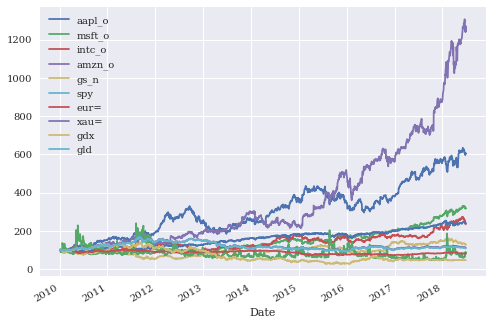

In [27]:
normalized = stocks.div(stocks.iloc[0]).mul(100)
normalized.plot()

## Resampling

Resampling is when you change the time period that you're looking at. So, you can go from daily to weekly to monthly, etc. This is called **downsampling** and involves aggregating your data.

You can also do the opposite and go from, say, monthly to daily. The new dates created in your data will be set as NaN. This is called **upsampling** and involves filling in missing data.

Let's start with `.asfreq` and some basic fill methods. I am going to "create" some quarterly data first for us to work with. I'll discuss how I do this in a minute. 

In [28]:
stocks_quarterly = stocks.resample('1q', label='right').last()
stocks_quarterly.head()

,aapl_o,msft_o,intc_o,amzn_o,gs_n,spy,_spx,_vix,eur=,xau=,gdx,gld
Date,,,,,,,,,,,,
2010-03-31,33.571395,29.2875,22.29,135.77,170.63,117.00,1169.43,17.59,1.3510,1112.80,44.41,108.95
2010-06-30,35.932821,23.0100,19.45,109.26,131.27,103.22,1030.71,34.54,1.2234,1241.35,51.96,121.68
2010-09-30,40.535674,24.4900,19.20,157.06,144.58,114.13,1141.20,23.70,1.3630,1308.50,55.93,127.91
2010-12-31,46.079954,27.9100,21.03,180.00,168.16,125.75,1257.64,17.75,1.3377,1419.45,61.47,138.72
2011-03-31,49.786736,25.3900,20.18,180.13,158.47,132.59,1325.83,17.74,1.4165,1430.00,60.10,139.86


Alright, we have some quarterly stock price data now. But, what I want to make this monthly data? Well, I don't have the actual monthly prices in this data set, but I can still **upsample** the data and go from quarterly to monthly.

In [29]:
stocks_monthly = stocks_quarterly.asfreq('M')
stocks_monthly.head()

,aapl_o,msft_o,intc_o,amzn_o,gs_n,spy,_spx,_vix,eur=,xau=,gdx,gld
Date,,,,,,,,,,,,
2010-03-31,33.571395,29.2875,22.29,135.77,170.63,117.00,1169.43,17.59,1.3510,1112.80,44.41,108.95
2010-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-30,35.932821,23.0100,19.45,109.26,131.27,103.22,1030.71,34.54,1.2234,1241.35,51.96,121.68
2010-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We now have new dates and missing values. We could fill in these missing values like we want. `.asfreq()' has different methods. I'll fill with the previous value, so that April and May get a March value, etc. This is called a **forward fill**. 

In [30]:
stocks_monthly = stocks_quarterly.asfreq('M', method='ffill')
stocks_monthly.head()

,aapl_o,msft_o,intc_o,amzn_o,gs_n,spy,_spx,_vix,eur=,xau=,gdx,gld
Date,,,,,,,,,,,,
2010-03-31,33.571395,29.2875,22.29,135.77,170.63,117.00,1169.43,17.59,1.3510,1112.80,44.41,108.95
2010-04-30,33.571395,29.2875,22.29,135.77,170.63,117.00,1169.43,17.59,1.3510,1112.80,44.41,108.95
2010-05-31,33.571395,29.2875,22.29,135.77,170.63,117.00,1169.43,17.59,1.3510,1112.80,44.41,108.95
2010-06-30,35.932821,23.0100,19.45,109.26,131.27,103.22,1030.71,34.54,1.2234,1241.35,51.96,121.68
2010-07-31,35.932821,23.0100,19.45,109.26,131.27,103.22,1030.71,34.54,1.2234,1241.35,51.96,121.68


`pandas` also has a method called `.resample`. This is **a lot** like a `.groupby()`, but dealing with time.

The code `stocks.resample('1w', label='right')` creates what `pandas` calls a `DatetimeIndexResampler` object. Basically, we are creating "bins" based on the time period we specify. I start with one week and then do one month. The argument `label='right'` tells `.resample()` which bin edge to label the bucket with. So, the first edge (i.e. the first date)
or the last edge (i.e. the last date). The option *right* means the last edge. For example, the bin will get labeled with the last day of the week. Or the last day of the month. The method `.last()` picks the last member of each time bin. So, we'll get get end-of-week prices or end-of-month prices.

You can find the documentation [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html). The fourth DataCamp assignment also goes over the details.

In [31]:
stocks.resample('1w', label='right').last().head()  

,aapl_o,msft_o,intc_o,amzn_o,gs_n,spy,_spx,_vix,eur=,xau=,gdx,gld
Date,,,,,,,,,,,,
2010-01-10,30.282827,30.66,20.83,133.52,174.31,114.57,1144.98,18.13,1.4412,1136.10,49.84,111.37
2010-01-17,29.418542,30.86,20.80,127.14,165.21,113.64,1136.03,17.91,1.4382,1129.90,47.42,110.86
2010-01-24,28.249972,28.96,19.91,121.43,154.12,109.21,1091.76,27.31,1.4137,1092.60,43.79,107.17
2010-01-31,27.437544,28.18,19.40,125.41,148.72,107.39,1073.87,24.62,1.3862,1081.05,40.72,105.96
2010-02-07,27.922829,28.02,19.47,117.39,154.16,106.66,1066.19,26.11,1.3662,1064.95,42.41,104.68


In [32]:
stocks.resample('1m', label='right').last().head()  

,aapl_o,msft_o,intc_o,amzn_o,gs_n,spy,_spx,_vix,eur=,xau=,gdx,gld
Date,,,,,,,,,,,,
2010-01-31,27.437544,28.1800,19.40,125.41,148.72,107.3900,1073.87,24.62,1.3862,1081.05,40.72,105.960
2010-02-28,29.231399,28.6700,20.53,118.40,156.35,110.7400,1104.49,19.50,1.3625,1116.10,43.89,109.430
2010-03-31,33.571395,29.2875,22.29,135.77,170.63,117.0000,1169.43,17.59,1.3510,1112.80,44.41,108.950
2010-04-30,37.298534,30.5350,22.84,137.10,145.20,118.8125,1186.69,22.05,1.3295,1178.25,50.51,115.360
2010-05-31,36.697106,25.8000,21.42,125.46,144.26,109.3690,1089.41,32.07,1.2267,1213.81,49.86,118.881


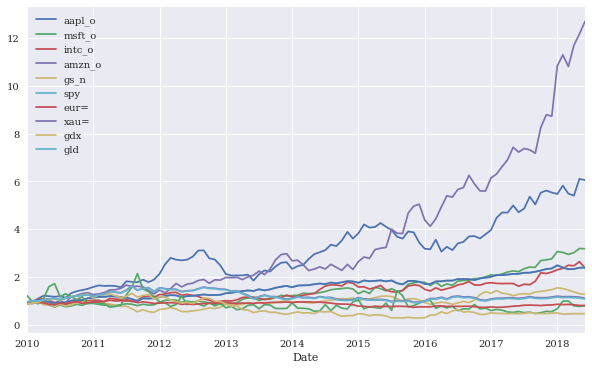

In [33]:
rets_log.cumsum().apply(np.exp).resample('1m', label='right').last(
                          ).plot(figsize=(10, 6));  

## Rolling statistics

Rolling statistics are your usual sorts of statistics, like a mean or standard deviation, but calculated with **rolling time windows**. So, the average price over the past month. Or, the standard deviation of returns of the past year. The value gets updated as you move forward in time - this is the rolling part.

Let's set a 20 day window and calculate some rolling statistics. There's one you might not know, a kind of moving average called an [exponentially weighted moving average](https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/exponentially-weighted-moving-average-ewma/) (ewma). 

In [34]:
window = 20  

stocks['aapl_min'] = stocks['aapl_o'].rolling(window=window).min()  
stocks['aapl_mean'] = stocks['aapl_o'].rolling(window=window).mean()  
stocks['aapl_std'] = stocks['aapl_o'].rolling(window=window).std()  
stocks['aapl_max'] = stocks['aapl_o'].rolling(window=window).max()  
stocks['aapl_ewma'] = stocks['aapl_o'].ewm(halflife=0.5, min_periods=window).mean()  

Let's make a plot using `pandas` `plot`. I'll select four variables and then pick just the last 200 observations using `.iloc`. Notice I don't need to include the index value. This is a line graph, so `.plot()` knows that you want this on the x-axis. I like how `.plot()` automatically styles the x-axis for us too.

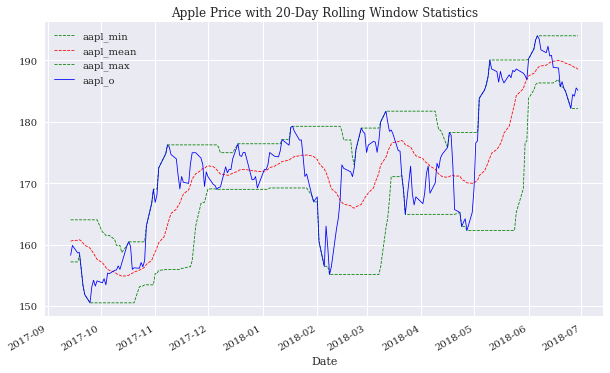

In [35]:
stocks[['aapl_min', 'aapl_mean', 'aapl_max', 'aapl_o']].iloc[-200:].plot(style=['g--', 'r--', 'g--', 'b'], lw=0.8, figsize=(10, 6), title = 'Apple Price with 20-Day Rolling Window Statistics');  



Now, I'll make the same graph using `matplotlib`. Again, I don't include the index value, as, by default, `matplotlib` will put it on the x-axis. I'm going to put four different line plots on the same axis. I am again selecting just the last 200 rows using `.iloc()`.

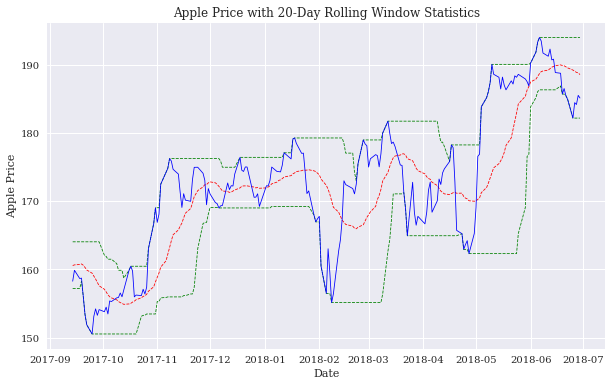

In [36]:
fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(1, 1, 1)

ax.plot(stocks.aapl_min.iloc[-200:], 'g--', lw=0.8)
ax.plot(stocks.aapl_mean.iloc[-200:], 'r--', lw=0.8)
ax.plot(stocks.aapl_max.iloc[-200:], 'g--', lw=0.8)
ax.plot(stocks.aapl_o.iloc[-200:], 'b', lw=0.8)

ax.set_xlabel('Date')
ax.set_ylabel('Apple Price')
ax.set_title('Apple Price with 20-Day Rolling Window Statistics');

Which way should you make your plots? Basically up to you! There are less verbose ways to do it that the `matplotlib` method I used above. I kind of like seeing each line like that, as it helps me read and understand what's going on. 

You could also select just the data you want, save it to a new DataFrame, and then plot.

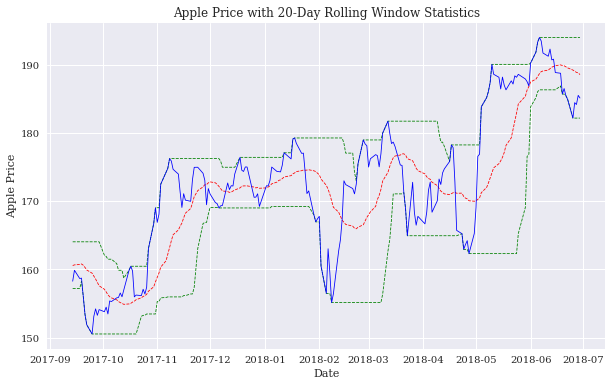

In [37]:
stocks_last200 = stocks.iloc[-200:]

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(1, 1, 1)

ax.plot(stocks_last200.aapl_min, 'g--', lw=0.8)
ax.plot(stocks_last200.aapl_mean, 'r--', lw=0.8)
ax.plot(stocks_last200.aapl_max, 'g--', lw=0.8)
ax.plot(stocks_last200.aapl_o, 'b', lw=0.8)

ax.set_xlabel('Date')
ax.set_ylabel('Apple Price')
ax.set_title('Apple Price with 20-Day Rolling Window Statistics');

### Simple trend indicator

One of the best known "anomalies" in finance is that stocks that have been doing better perform better in the future, and vice-versa. This general set of anomalies are called **momentum and trend**. Here's a [summary of momentum and why it might exist](https://www.aqr.com/Insights/Research/White-Papers/Explanations-for-the-Momentum-Premium). The hedge fund Two Sigma has a brief explanation of how [trend and momentum](https://www.venn.twosigma.com/vennsights/momentum-and-trend-following) are different. And a more [academic explanation](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2089463). 

We can calculate basic moving averages that might capture the spirit of **trend**. We want stocks that are outperforming their longer history in the short-term. We can measure this with two different **simple moving averages** (sma). 

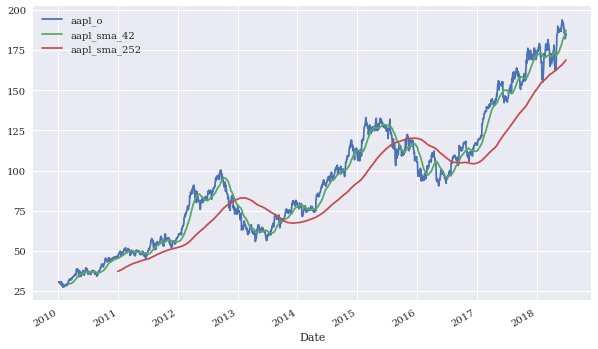

In [38]:
stocks['aapl_sma_42'] = stocks['aapl_o'].rolling(window=42).mean()
stocks['aapl_sma_252'] = stocks['aapl_o'].rolling(window=252).mean()  

stocks[['aapl_o', 'aapl_sma_42', 'aapl_sma_252']].plot(figsize=(10, 6));  


Let's create an indicator (1/0) variable that is 1 if the two-month moving average is above the one-year moving average. This would be example of a simple **short-term trend** strategy. You buy the stock if it is doing better now than it has in over the past year. You do not own the stock otherwise.

I will then graph the moving averages, the price, and the indicator, called **take_position**, on the same graph. I'm going to do something a bit different, but you'll see it in our text. I will use `pandas` `.plot()` to make the graph, but save this to an **axes object**. I can then refer to the **ax** object when styling. This kind of mixes two ways that we've seen plot and figure creation!

Notice the creation of a secondary y-axis for the indicator variable.

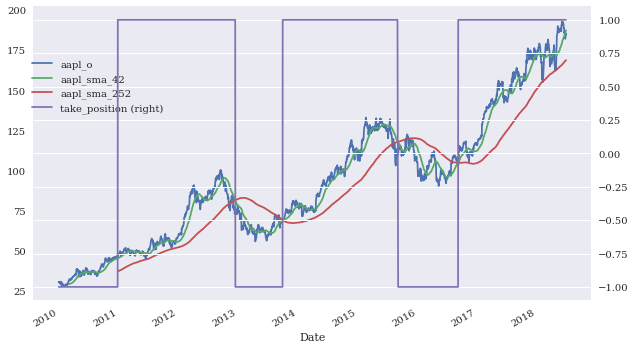

In [39]:
stocks['take_position'] = np.where(stocks['aapl_sma_42'] > stocks['aapl_sma_252'], 1, -1)  

ax = stocks[['aapl_o', 'aapl_sma_42', 'aapl_sma_252', 'take_position']].plot(figsize=(10, 6), secondary_y='take_position')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85));

What do you think? Did this strategy work for trading Apple during the 2010s? We'll look more at **backtesting strategies** and all of the issues that arise later on.

## Correlation and regression

We'll look at some simple correlation and linear regression calculations. We'll do more with regression later on.

Let's look at the relationship between the S&P 500 and the Apple. I'll bring the stocks data again, but just keep these two time series. I won't bother cleaning the names. `pyjanitor` replaces the . in front of `.SPX` with an underscore and `plot()` doesn't like that when making the legend.

In [40]:
# Read in some eod prices
stocks2 = pd.read_csv('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)  

stocks2.dropna(inplace=True)  

stocks2 = stocks2[['.SPX', 'AAPL.O']]


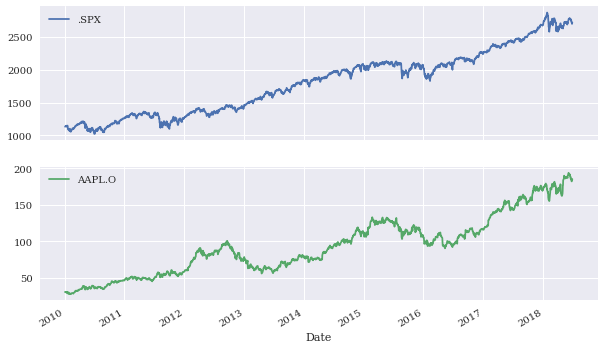

In [41]:
stocks2.plot(subplots=True, figsize=(10, 6));


In [42]:
rets2 = np.log(stocks2 / stocks2.shift(1)) 

rets2.dropna(inplace=True)

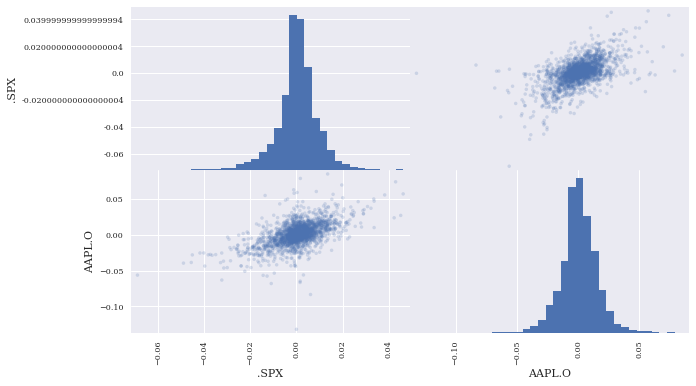

In [43]:
pd.plotting.scatter_matrix(rets2,
                           alpha=0.2,  
                           diagonal='hist',  
                           hist_kwds={'bins': 35},  
                           figsize=(10, 6));

We can run a simple linear regression using `np.polyfit` from the `numpy` library. Other libraries have more sophisticated tools. We'll set `deg=1` since this is a linear regression (i.e. degree of 1). 

In [44]:
reg = np.polyfit(rets2['.SPX'], rets2['AAPL.O'], deg=1)  
reg

array([9.57422130e-01, 4.50598662e-04])

Apple has a beta of 0.957 (note the scientific notation in the output). The intercept (or alpha) is the next number and is based on daily returns. 

In [45]:
rets2.corr()  

,.SPX,AAPL.O
.SPX,1.000000,0.563036
AAPL.O,0.563036,1.000000


## Generating random returns

We are going to look more at distributions and what are called Monte Carlo methods when we get to risk management, simulations, and option pricing. But, for now, let's look at a simple case of generating some random returns that "look" like actual stock returns.

Let's create 1000 random numbers from a normal distribution with a mean of 0 and a standard deviation of 0.01 (1%). This means that we "pull" these numbers out of that distribution. We can then plot them (using `seaborn`, for fun) and include a normal distribution that fits the distribution of random numbers. 

<AxesSubplot:>

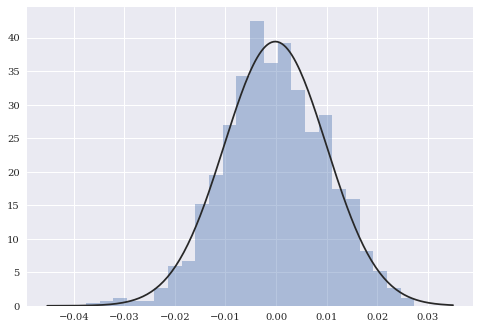

In [46]:
seed(1986)
random_returns = normal(loc=0, scale=0.01, size=1000)
sns.distplot(random_returns, fit=norm, kde=False)

Looks like a bell curve to me. Let's take that set of 1000 random numbers and turn them into a `pd.Series`. We can then treat them like actual returns and create a cumulative return series, like above.

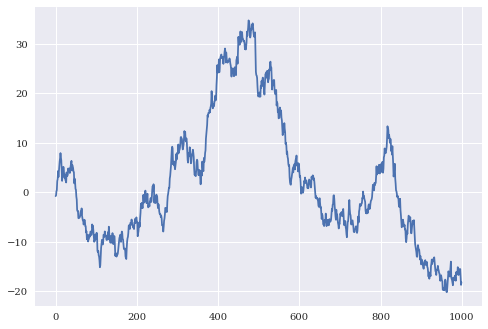

In [47]:
return_series = pd.Series(random_returns)
random_prices = return_series.add(1).cumprod().sub(1)
random_prices.mul(100).plot();

And there you go! Some fake returns. Stocks returns aren't actually normally distributed like this, at least over short windows. Simulations and Monte Carlo methods are used a lot in wealth management to figure out the probability that a client will meet their retirement goals.